## Análisis exploratorio de Datos de los Datasets Checkin, Tips y User

Se importan las librerias necesarias para el procesamiento de datos 

In [26]:
import pandas as pd
import numpy as np
from scipy import stats
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.json as pj
import seaborn as sns
import matplotlib.pyplot as plt

## Archivo Check-in

In [27]:
checkin = pd.read_json("Datasets\checkin.json", lines=True)
checkin.head()

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


Se observa la información de las columnas la cantidad de no nulos y su tipo de dato 

In [28]:
checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131930 entries, 0 to 131929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  131930 non-null  object
 1   date         131930 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


Se utiliza explode para transformar cada elemento de la lista en la columna "date" en una fila separada

In [29]:
df_checkin = checkin.copy()
df_checkin["date"] = df_checkin["date"].str.split(',')
df_checkin = df_checkin.explode("date")
df_checkin.head()

,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,2020-03-13 21:10:56
0,---kPU91CF4Lq2-WlRu9Lw,2020-06-02 22:18:06
0,---kPU91CF4Lq2-WlRu9Lw,2020-07-24 22:42:27
0,---kPU91CF4Lq2-WlRu9Lw,2020-10-24 21:36:13
0,---kPU91CF4Lq2-WlRu9Lw,2020-12-09 21:23:33


Luego del explode en la columna date notamos que aumentaron las filas

In [30]:
df_checkin = df_checkin.reset_index(drop=True)
df_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13356875 entries, 0 to 13356874
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   business_id  object
 1   date         object
dtypes: object(2)
memory usage: 203.8+ MB


Se observa si hay nulos

In [31]:
df_checkin.isnull().sum()  

business_id    0
date           0
dtype: int64

Se observa si  hay duplicados

Se observa si hay Outiers

In [32]:
def outliers(checkin):
    for columna in checkin:
        if checkin[columna].dtype != np.object_:
            n_outliers = len(checkin[np.abs(stats.zscore(checkin[columna])) > 3])
            print("{} | {} | {}".format(
                checkin[columna].name,
                n_outliers,
                checkin[columna].dtype
        ))

outliers(checkin)

In [33]:
# Se cargan los restaurantes latinoamericanos de Yelp para filtrar los registros de restaurantes:
latin_res = pd.read_parquet("Data/Restaurants_Yelp.parquet")
latin_res.head()

,business_id,name,address,city,postal_code,latitude,longitude,stars,review_count
0,du_yelFmWOZDEyIAE-jdsQ,Taco Del Mar,"1515-Poydras St, Ste 160",New Orleans,70112,29.952248,-90.078264,2.0,9
1,k9A4tAmei12tLprkrNPkcg,El Pollo Loco,10320 N Mccarran Blvd,Reno,89503,39.532104,-119.864028,3.5,54
2,ERl6OCSEIFBOqfjai_jIUg,La Parrilla Suiza,2720 N Oracle Rd,Tucson,85705,32.256420,-110.977460,3.0,125
3,VaPj2Mpu0IpsUoisyTCAUg,That Awesome Taco Truck,,Nashville,37206,36.180519,-86.726548,3.5,11
4,Qi-A4ZgcEuSnq_8Fpfo_3Q,Our Lady of Guadalupe Mercado,227 N Nopal St,Santa Barbara,93103,34.423080,-119.684008,4.5,8


In [34]:
# Se filtran los checkin de los restaurantes objetivo:
restaurantes = latin_res["business_id"].unique()
df_checkin = df_checkin[df_checkin["business_id"].isin(restaurantes)]
df_checkin = df_checkin.reset_index(drop=True)
df_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27572 entries, 0 to 27571
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  27572 non-null  object
 1   date         27572 non-null  object
dtypes: object(2)
memory usage: 430.9+ KB


In [35]:
# Se cambia el tipo de columna date de "string" a "datetime"
df_checkin["date"] = df_checkin["date"].str.strip()
df_checkin["date"] = pd.to_datetime(df_checkin["date"])
df_checkin.head()

,business_id,date
0,-nEsM53i_wmt9wpSlQm1Rg,2015-05-18 18:06:01
1,-nEsM53i_wmt9wpSlQm1Rg,2017-05-08 18:47:25
2,-nEsM53i_wmt9wpSlQm1Rg,2017-05-22 17:08:02
3,-nEsM53i_wmt9wpSlQm1Rg,2017-06-19 18:23:13
4,-nEsM53i_wmt9wpSlQm1Rg,2018-08-29 20:20:12


In [36]:
# Se deja unicamente la fecha y se crea la columna "año"
df_checkin["ano"] = df_checkin["date"].dt.year
df_checkin["date"] = df_checkin["date"].dt.date
df_checkin.head()

,business_id,date,ano
0,-nEsM53i_wmt9wpSlQm1Rg,2015-05-18,2015
1,-nEsM53i_wmt9wpSlQm1Rg,2017-05-08,2017
2,-nEsM53i_wmt9wpSlQm1Rg,2017-05-22,2017
3,-nEsM53i_wmt9wpSlQm1Rg,2017-06-19,2017
4,-nEsM53i_wmt9wpSlQm1Rg,2018-08-29,2018


In [38]:
df_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27572 entries, 0 to 27571
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  27572 non-null  object
 1   date         27572 non-null  object
 2   ano          27572 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 538.6+ KB


In [37]:
# Se exporta el archivo en formato parquet:
df_checkin.to_parquet("Checkin_restaurantes_yelp_completo.parquet")

In [40]:
# Se establece el corte de la carga original
chekin_hasta19 = df_checkin[df_checkin["ano"] <= 2019].reset_index(drop=True)
chekin_hasta19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24962 entries, 0 to 24961
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  24962 non-null  object
 1   date         24962 non-null  object
 2   ano          24962 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 487.7+ KB


In [41]:
# Se establece el corte de la carga incremental
chekin_incremental = df_checkin[df_checkin["ano"] > 2019].reset_index(drop=True)
chekin_incremental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  2610 non-null   object
 1   date         2610 non-null   object
 2   ano          2610 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 51.1+ KB


In [ ]:
# Se exportan ambos archivos en formato parquet:
chekin_hasta19.to_parquet("Checkin_restaurantes_hasta19.parquet")
chekin_incremental.to_parquet("Checkin_restaurantes_incremental.parquet")

## Archivo Tips

In [11]:
tips = pd.read_json("Datasets\\tip.json", lines=True)
tips.head()

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


Se observa la información de las columnas la cantidad de no nulos y su tipo de dato 

In [12]:
tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908915 entries, 0 to 908914
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           908915 non-null  object        
 1   business_id       908915 non-null  object        
 2   text              908915 non-null  object        
 3   date              908915 non-null  datetime64[ns]
 4   compliment_count  908915 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 34.7+ MB


Se observan los valores de la columna compliment_count

In [13]:
tips["compliment_count"].value_counts()

compliment_count
0    898376
1      9821
2       617
3        82
4        14
5         3
6         2
Name: count, dtype: int64

Se observa si hay nulos 

In [14]:
tips.isna().sum()

user_id             0
business_id         0
text                0
date                0
compliment_count    0
dtype: int64

Se observa si hay duplicados

In [15]:
tips.duplicated().sum() 

67

Se observan las filas duplicadas

In [16]:
duplicados = tips[tips.duplicated(keep=False)]

print("Filas completas con valores duplicados en todo el DataFrame:")
duplicados


Filas completas con valores duplicados en todo el DataFrame:


,user_id,business_id,text,date,compliment_count
1644,SNZJNz1WEIMECEk-TAYADQ,6Gx45ltNNZvjzVBO6ZgVOg,"Great food, fun place!",2017-10-10 20:13:08,0
11367,00Cz_vdInMHpTRjqbWjK5Q,ncacMQ9n_dSM1cR3c1vTQw,Miss saigon,2010-12-07 01:59:12,0
21583,Tf63LdfubjlFm974OrdTXg,CyiN_owscPJNvlwul0XJPg,LM,2011-11-22 12:48:02,0
29901,00Cz_vdInMHpTRjqbWjK5Q,ncacMQ9n_dSM1cR3c1vTQw,Miss saigon,2010-12-07 01:59:12,0
32192,y_PMpgAxTWUIYAmzfFc6VA,Bw0cpnfI-Y9QmjWzqS-oFg,Late dinner w @steinerrecliner,2011-01-31 01:07:40,0
...,...,...,...,...,...
820290,wYo3aBVj-bRPT7E4RSj5Kg,W5SNps2JaT_RozLAl_TN1Q,Worker there are the best at serving me quick ...,2017-12-17 01:10:52,0
869840,TEjijSowDwJM4vCL-zn4ew,YPHDzg1h-PkaxfoppT-iJg,bleed blue,2011-09-26 00:03:49,0
873070,TEjijSowDwJM4vCL-zn4ew,YPHDzg1h-PkaxfoppT-iJg,bleed blue,2011-09-26 00:03:49,0
900543,XJcb75c9OY0xX8spM0TQuw,UlGS2NxZSiph33E3nfovRw,Whiskey Kitchen is the perfect place for bar f...,2013-08-04 16:43:08,0


Se eliminan los duplicados

In [17]:
tips = duplicados.drop_duplicates()

Se hace reset index de las filas 

In [18]:
tips.reset_index(inplace=True, drop=True)

Se verifican que ya no hayan duplicados en las filas

In [19]:
tips.duplicated().sum()

0

Se elimina la columna compliment_count ya que se considera que no tiene información relevante 

In [20]:
tips = tips.drop(columns="compliment_count")

In [21]:
tips.head()

,user_id,business_id,text,date
0,SNZJNz1WEIMECEk-TAYADQ,6Gx45ltNNZvjzVBO6ZgVOg,"Great food, fun place!",2017-10-10 20:13:08
1,00Cz_vdInMHpTRjqbWjK5Q,ncacMQ9n_dSM1cR3c1vTQw,Miss saigon,2010-12-07 01:59:12
2,Tf63LdfubjlFm974OrdTXg,CyiN_owscPJNvlwul0XJPg,LM,2011-11-22 12:48:02
3,y_PMpgAxTWUIYAmzfFc6VA,Bw0cpnfI-Y9QmjWzqS-oFg,Late dinner w @steinerrecliner,2011-01-31 01:07:40
4,3nBDXQT81w91zv8NPke8Mw,2JEzWTF9tazzjyzCTsOWQw,Very friendly staff. I really like this offic...,2017-09-27 18:29:38


## Archivo user

In [2]:
usuarios = pd.read_parquet(r"Datasets\\user-002.parquet", engine="pyarrow")
usuarios.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


Se muestra la información de las columnas

In [3]:
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105597 entries, 0 to 2105596
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 353.4+ MB


Se muestra la cantidad de nulos

In [4]:
usuarios.isnull().sum()

user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

Se eliminan las columnas que se consideran irrelevantes

In [5]:
# Lista de columnas para eliminar
columnas_eliminar = ['useful','funny','cool','elite','friends','fans','compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 
                     'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 
                     'compliment_photos']

# Elimina las columnas
usuarios = usuarios.drop(columns=columnas_eliminar)

In [6]:
usuarios.head()

,user_id,name,review_count,yelping_since,average_stars
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,3.91
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,3.74
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,3.32
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,4.27
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,3.54


In [7]:
def outliers(usuarios):
    for columna in usuarios:
        if usuarios[columna].dtype != np.object_:
            n_outliers = len(usuarios[np.abs(stats.zscore(usuarios[columna])) > 3])
            print("{} | {} | {}".format(
                usuarios[columna].name,
                n_outliers,
                usuarios[columna].dtype
        ))

outliers(usuarios)

review_count | 26376 | int64
average_stars | 0 | float64


In [8]:
usuarios.duplicated().sum()

117700

In [25]:
# Elimina los duplicados
usuarios.drop_duplicates(inplace=True)

# Muestra el DataFrame resultante
usuarios

,user_id,name,review_count,yelping_since,average_stars
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,3.91
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,3.74
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,3.32
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,4.27
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,3.54
...,...,...,...,...,...
1987892,fB3jbHi3m0L2KgGOxBv6uw,Jerrold,23,2015-01-06 00:31:31,4.92
1987893,68czcr4BxJyMQ9cJBm6C7Q,Jane,1,2016-06-14 07:20:52,5.00
1987894,1x3KMskYxOuJCjRz70xOqQ,Shomari,4,2017-02-04 15:31:58,2.00
1987895,ulfGl4tdbrH05xKzh5lnog,Susanne,2,2011-01-14 00:29:08,3.00


## EDA

In [10]:
usuarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105597 entries, 0 to 2105596
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   name           object 
 2   review_count   int64  
 3   yelping_since  object 
 4   average_stars  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 80.3+ MB


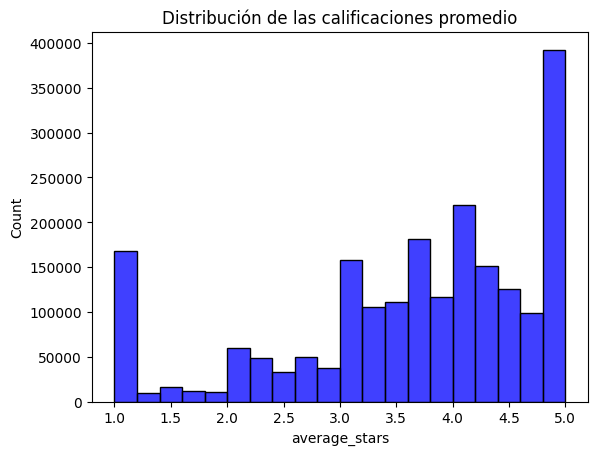

In [46]:
sns.histplot(data=usuarios, x='average_stars', bins=20, color='blue')
plt.title('Distribución de las calificaciones promedio')
plt.show()

In [17]:
plt.clf()

<Figure size 640x480 with 0 Axes>

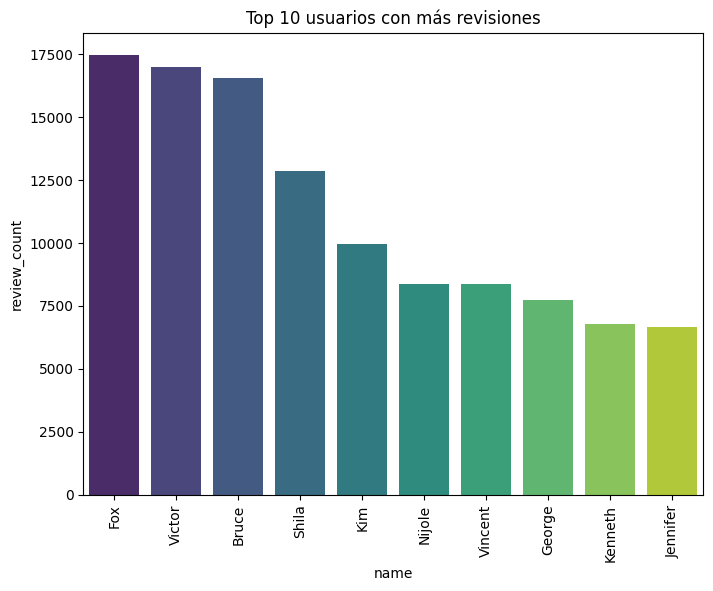

In [45]:
df_sorted = usuarios.sort_values(by='review_count', ascending=False)
top_users = df_sorted.head(10)


plt.figure(figsize=(8, 6))
sns.barplot(data=top_users, x='name', y='review_count', palette='viridis')
plt.xticks(rotation=90)
plt.title('Top 10 usuarios con más revisiones')
plt.show()